# Evaluating how transcripts/cell data normalization performs in comparison to TPM

Transcripts/cell is defined as:

$$transcripts_i.cell^{-1} = \frac{counts_i \hat{R_{st}}}{A_c} \;\; (1)$$

where,

$R_{{st}_j} = \frac{molecules_j}{counts_j}$

$A_c :=$ total cell abundance.

From the above definition, we see that:

1. count data are not normalized by transcript length
2. count data are not normalized by total RNA abundance

Thus, the transformation carried out in (1) assumes:

1. number of aligned reads independent of transcript length
2. the "dilution" of each transcript is similar to internal standard (not comparable across conditions, whereas transcripts/cell should.

Additionally, the above transformation adds new sources of experimental error in the quantities $R_{st}$ and $A_c$, both in a multiplicative manner.

In [18]:
p = {'st': 10, 'a': 10, 'b': 60, 'c': 20}
q = {'st': 10, 'a': 30, 'b': 30, 'c': 30}

{'st': 10, 'a': 10, 'b': 60, 'c': 20}

In the above example, we have two conditions, p and q, three genes, a, b and c and an internal standard. The quantity of internal standard, and hence, its "dilution", is the same in the two conditions. However, the proportion of transcripts of each gene varies, and the dilution of each genes differs between conditions. Therefore, using the same standard ratio for all genes may produce over or underestimates of transcripts per cell.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import copy
from matplotlib import pyplot as plt
import Dokdonia_code as Dc
%matplotlib inline

In [2]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv('Data/DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


In [3]:
# Loading Internal Standard counts and removing genes with low read counts across samples
min_count = 10

IS_counts = pd.read_csv('Data/Laura_Normalization/SulfoStandardsCounts.csv', index_col=0)
IS_counts = IS_counts[IS_counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in IS_counts.columns]
IS_counts.columns = conditions
IS_counts = IS_counts[(IS_counts > min_count).all(1)]
IS_counts.reset_index(level=0, inplace=True)
IS_counts

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,s3_pdhD_v1_1000_Frag,72598,49476,44781,41976,45059,61529,43659,238,38833,...,44528,62015,83731,71613,70473,68516,57863,50533,45087,66020
1,s6_hyp1378_v1_964_Frag,72653,47522,60846,43220,43982,55793,50789,215,41727,...,53412,68243,88206,70797,66017,76033,58339,51977,55047,65414
2,s7_hyp1273_v1_991_Frag,52469,37019,55667,33402,37222,47338,38300,217,34221,...,49129,55926,84796,54971,49270,72528,46602,48531,45793,53807
3,s13_therm_v1_613_Frag,114019,71758,97845,66170,75550,98543,80188,368,68877,...,97668,110083,146095,112836,96878,126030,93214,85357,86459,104693
4,s14_virB_v1_301_Frag,76247,54063,90804,59967,72004,81346,64649,327,59965,...,66344,99487,137419,85065,82237,120758,88558,92649,86015,101281
5,s15_alpha_v1_1504_Frag,33805,23077,17434,20281,20625,37129,21961,152,20046,...,19517,25030,32513,37034,34845,30555,26086,21041,18819,42985


In [4]:
# Load and format standards data
standards_data = pd.read_excel('Data/Laura_Normalization/Standards_Dokdonia.xlsx', index_col=0)
standards_data.reset_index(level=0, inplace=True)
standards_data = standards_data[(standards_data['Standard'].notna()) & (standards_data['Sample ID'].notna())]
standards_data['Standard'] = standards_data['Standard'].apply(lambda s: s.strip())
standards_data['Sample ID'] = standards_data['Sample ID'].apply(lambda s: s.strip())
standards_data.head()

,Sample ID,Standard,Standard reads counts,Standard stock (pg/uL),Volume added (uL),Standard added (pg),Length (bp),MW (g/mol),Avogadro (molec/mol),moleculas/gr,Standard added (copias),Standard ratio,Avg Standard ratio,DesvS ratio,CV
0,L_10_R1,s13_therm_v1_613_Frag,201008.0,25.807806,20.0,516.15611,613.0,208420.0,6.022000e+23,2.889358e+18,1.491360e+09,7419.405196,8361.014907,3315.683084,39.656467
1,L_10_R1,s14_virB_v1_301_Frag,121484.0,14.993974,20.0,299.87948,301.0,102340.0,6.022000e+23,5.884307e+18,1.764583e+09,14525.229550,NaN,NaN,NaN
2,L_10_R1,s15_alpha_v1_1504_Frag,58100.0,14.230661,20.0,284.61321,1504.0,511360.0,6.022000e+23,1.177644e+18,3.351730e+08,5768.898780,NaN,NaN,NaN
3,L_10_R1,s3_pdhD_v1_1000_Frag,124049.0,22.149535,20.0,442.99070,1000.0,340000.0,6.022000e+23,1.771176e+18,7.846147e+08,6325.038529,NaN,NaN,NaN
4,L_10_R1,s6_hyp1378_v1_964_Frag,126235.0,22.246123,20.0,444.92246,964.0,327760.0,6.022000e+23,1.837320e+18,8.174649e+08,6475.739136,NaN,NaN,NaN


In [5]:
# load and format abundance data
abundance_meta = pd.read_excel('Data/Laura_Normalization/Abundancias_Dokdonia.xlsx', index_col=0)
abundance_meta.reset_index(level=0, inplace=True)
abundance_meta = abundance_meta[abundance_meta['Sample'].notna()]
abundance_meta['Sample'] = abundance_meta['Sample'].apply(lambda s: s.strip())
abundance_meta.head()

,Sample,Avg_Standard_ratio,Abundancia_cells_mL,Vol_filtered_mL,Total_cell_abundance
0,L_10_R1,8361.014907,1.521921e+06,500,7.609607e+08
1,L_10_R2,25169.662201,1.086850e+06,500,5.434251e+08
2,L_10_R3,21891.978025,1.219073e+06,500,6.095364e+08
3,D_10_R1,14032.230064,1.135166e+06,490,5.562311e+08
4,D_10_R2,20613.230047,1.170827e+06,500,5.854134e+08


In [6]:
# Compute Transcripts/Cell (Would check how replicate variance changed after transformation)
avg_st_ratios = Dc.getAverageStandardRatio(IS_counts, standards_data)
n_counts = Dc.getTranscriptsPerCell(counts, avg_st_ratios, abundance_meta)
# n_counts.to_csv('Data/Dokdonia_transcripts_cell.csv')
n_counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R2,D_25_R3,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,0.327274,0.402326,0.319319,1.504600,2.588597,1.816263,NaN,1.252534,1.377925,...,1.024204,0.600671,NaN,1.162753,1.091035,1.497091,0.894585,0.969526,1.271870,1.474154
1,MED134_07384,0.039279,0.054754,0.037400,0.204387,0.370730,0.247459,NaN,0.174478,0.189857,...,0.161554,0.075332,NaN,0.159744,0.144771,0.215060,0.121708,0.148669,0.199779,0.199276
2,MED134_07379,0.085773,0.116867,0.078872,0.354630,0.668159,0.422425,NaN,0.293002,0.369985,...,0.288264,0.134483,NaN,0.267931,0.235775,0.344913,0.229589,0.238353,0.336011,0.352442
3,MED134_07374,0.050127,0.074789,0.033833,0.172402,0.318904,0.192060,NaN,0.128314,0.152053,...,0.113289,0.064169,NaN,0.105710,0.093986,0.141055,0.093785,0.096881,0.122292,0.135680
4,MED134_07369,0.052649,0.070775,0.050870,0.185422,0.322032,0.198658,NaN,0.133732,0.137702,...,0.160357,0.086695,NaN,0.109218,0.108735,0.152055,0.124460,0.111494,0.126488,0.131270


# Cluster transcript/cell data with Clust (no additional normalization)

In [8]:
# Do not discriminate between Light and Dark conditions
p_value_cutoff = 1e-2
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = Dc.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = Dc.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')

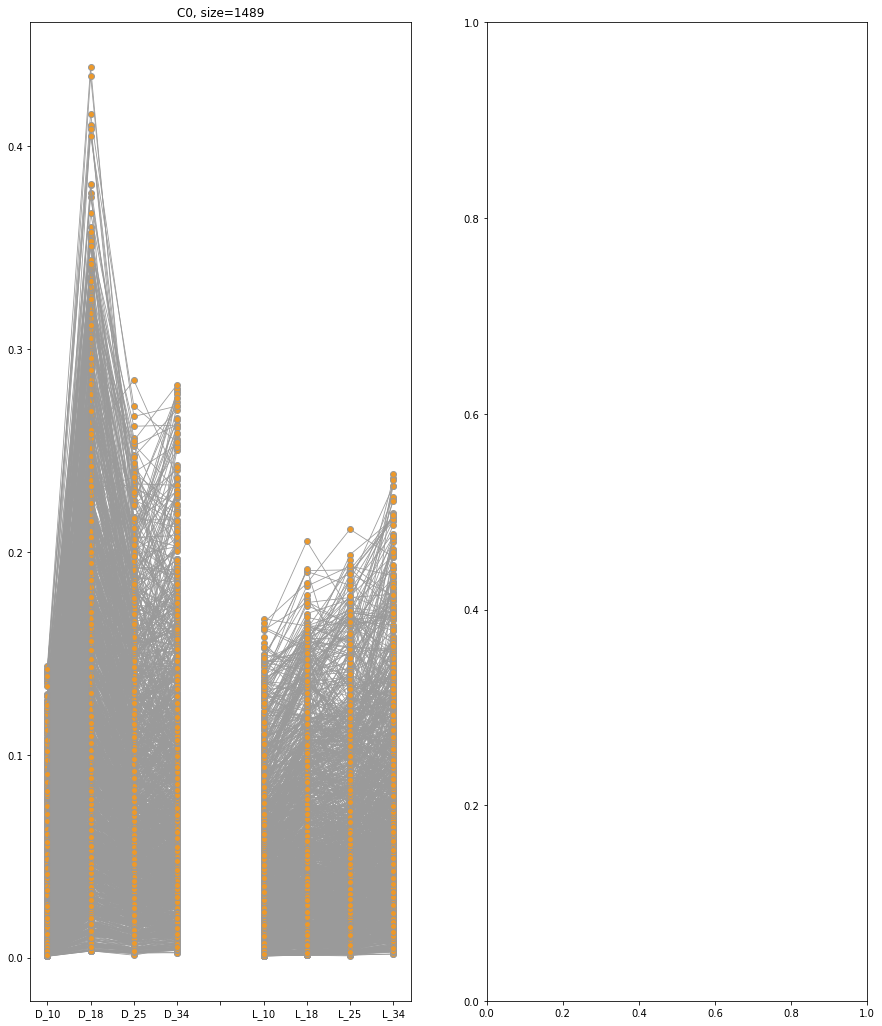

In [12]:
clust_data = n_counts
clust_data = clust_data[clust_data.filter(regex='^[^T]+$').columns]
clust_data= clust_data.set_index('index')
clust_data.index.name = 'ID'

# Cluster only DE genes across temperatures (n_counts)
# Doesn't produce meaningful clusters
res_id = 'CLUSTER_DE_GENES_TRANSCRIPT_CELL'
gene_ids = T_res['all'].index
workdir = os.path.join(os.getcwd(),'Results')
DE_data = clust_data[clust_data.index.isin(gene_ids)]
clusters = Dc.getGeneClusters(DE_data, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=1, input_data_normalization=False)

pdata = pd.read_csv(os.path.join(
    os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
pdata.insert(4, '', [np.nan for n in range(pdata.shape[0])])

Dc.plotClusters(pdata, clusters)

# Cluster transcript/cell data with Clust (same normalization applied to TPM values)

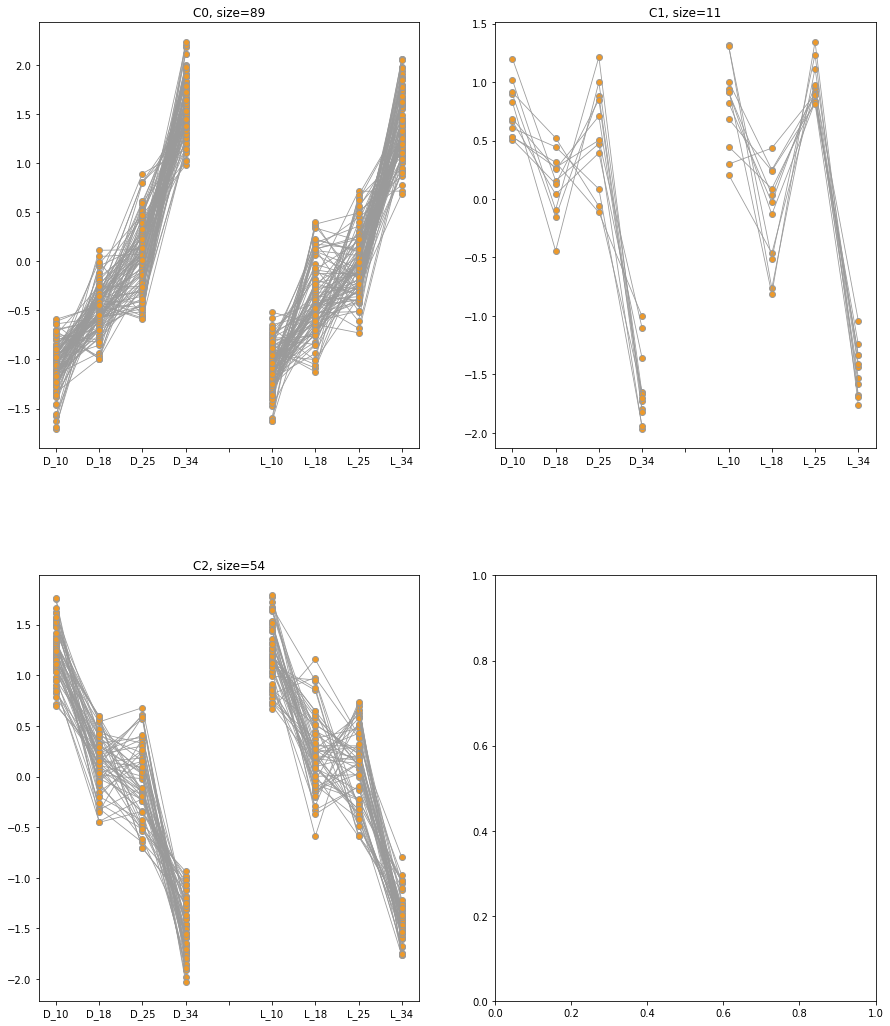

In [17]:
clust_data = n_counts
clust_data = clust_data[clust_data.filter(regex='^[^T]+$').columns]
clust_data= clust_data.set_index('index')
clust_data.index.name = 'ID'

# Cluster only DE genes across temperatures (n_counts)
# Doesn't produce meaningful clusters
res_id = 'CLUSTER_DE_GENES_TRANSCRIPT_CELL'
gene_ids = T_res['all'].index
workdir = os.path.join(os.getcwd(),'Results')
DE_data = clust_data[clust_data.index.isin(gene_ids)]
clusters = Dc.getGeneClusters(DE_data, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=1, input_data_normalization=True)

pdata = pd.read_csv(os.path.join(
    os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
pdata.insert(4, '', [np.nan for n in range(pdata.shape[0])])

Dc.plotClusters(pdata, clusters)